# CAPM

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import gurobipy as gb

%matplotlib inline
plt.style.use("ggplot")

In [11]:
portfolio_tickers = ["SPY","ACWX","SCHO","BNDX","USO"]

ticker_set = dict()
for year in range(2010,2021):
    ticker_set[year] = portfolio_tickers
ticker_set

{2010: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2011: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2012: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2013: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2014: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2015: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2016: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2017: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2018: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2019: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2020: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO']}

[*********************100%***********************]  5 of 5 completed


,ACWX,BNDX,SCHO,SPY,USO
Date,,,,,
2016-11-01,-0.003926,-0.001974,0.000631,-0.007245,0.003799
2016-11-02,-0.008623,0.002541,0.000000,-0.006019,-0.027436
2016-11-03,-0.001242,-0.001629,0.000197,-0.004577,-0.019455
2016-11-04,-0.009206,0.000907,0.000394,-0.001102,-0.009921
2016-11-07,0.021095,0.000000,-0.000394,0.022057,0.018036


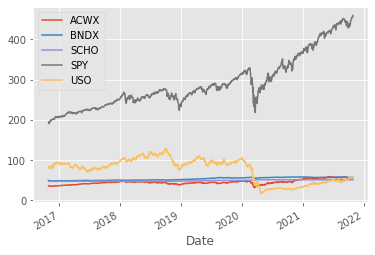

In [16]:
portfolio_tickers = ["SPY","ACWX","SCHO","BNDX","USO"]
stocks = yf.Tickers(" ".join(portfolio_tickers))
stock_data = stocks.download(period= "5y")["Close"]
stock_data.plot()
stock_data = stock_data.pct_change()[1:]
stock_data.head()

In [13]:
covarience = np.cov(stock_data.cov())
stock_data.cov()

,ACWX,BNDX,SCHO,SPY,USO
ACWX,0.000127,3.052852e-06,-1.974823e-06,0.000118,1.118098e-04
BNDX,0.000003,3.744383e-06,4.013758e-07,0.000002,-2.446950e-07
SCHO,-0.000002,4.013758e-07,3.543834e-07,-0.000002,-2.907075e-06
SPY,0.000118,2.308856e-06,-2.456252e-06,0.000139,1.132602e-04
USO,0.000112,-2.446950e-07,-2.907075e-06,0.000113,6.709956e-04


In [6]:
e_returns = np.array(stock_data.mean())
e_returns

array([4.30802621e-04, 1.11700755e-04, 6.06367518e-05, 7.55046285e-04,
       3.87722311e-05])

# Gurobi

In [7]:
def print_equations(obj, constraint, sense, b):
    print("Optimise System of equations:")
    for i in range(constraint.shape[0]):
        char = "a"
        print("\t"+str(i+1)+")",end=" ")
        for j in range(constraint.shape[1]):
            print(str(constraint[i,j])+char,end=" + ")
            char = chr(ord(char) + 1)
        print("\b\b "+sense[i]+"= "+str(b[i]))
    char = "a"
    print("Subject to:", end=" ")
    for item in obj:
        print(str(item)+char,end=" + ")
        char = chr(ord(char) + 1)
    print("\b\b")
    return

# Minimimum Risk Portfolio

In [8]:
variables = len(portfolio_tickers)

constraints = 1     # Shorting of stocks allowed
# constraints += variables      # No-=Shorting of stocks allowed


model = gb.Model("Portfoli0")
model_X = model.addMVar(variables)
risk = model_X@covarience@model_X

A = np.zeros((constraints,variables)) # initialize constraint matrix
A[0] = np.ones((1,variables)) # Sum of weights = 1
if constraints>1:
    A[1:] = np.diag(e_returns) # No shorting

b = np.array([1]+[0]*(constraints-1))

sense = np.array(["="]+[">"]*(constraints-1))

print_equations(np.array([0]*variables), A, sense,b)

Restricted license - for non-production use only - expires 2022-01-13
Optimise System of equations:
	1) 1.0a + 1.0b + 1.0c + 1.0d + 1.0e  == 1
Subject to: 0a + 0b + 0c + 0d + 0e 


In [9]:

model_constraints = model.addMConstrs(A, model_X, sense, b)
model.setObjective(risk, sense=gb.GRB.MINIMIZE)
model.Params.OutputFlag = 0

model.optimize()
optimal_obj = model.objVal
optimal_values = model_X.x

print()
print("Least Risk:", optimal_obj)

lrisk_weights = np.round(optimal_values,2)
lrisk_returns = lrisk_weights@e_returns.T
lrisk_vol = np.sqrt(lrisk_weights.T@covarience@lrisk_weights)

print("Least Risk Portfolio Weights:", lrisk_weights)
print("Least Risk Portfolio E(returns): ",lrisk_returns*100,"%")
print("Least Risk Portfolio Volatility: ",np.round(lrisk_vol,5))


Least Risk: 6.65116934572034e-10
Least Risk Portfolio Weights: [0.08 0.35 0.42 0.08 0.07]
Least Risk Portfolio E(returns):  0.016214466879910624 %
Least Risk Portfolio Volatility:  3e-05


# Maximise Sharpe Ratio

[reference](https://support.gurobi.com/hc/en-us/community/posts/360074491212-Divisor-must-be-a-constant)

In [9]:
variables = len(portfolio_tickers)

constraints = 1     # Shorting of stocks allowed
constraints += variables      # No-=Shorting of stocks allowed


model = gb.Model("Portfoli0")
model_X = model.addMVar(variables)
risk = model_X@covarience@model_X

A = np.zeros((constraints,variables)) # initialize constraint matrix
A[0] = e_returns # Sum of weights = 1
if constraints>1:
    A[1:] = np.diag(e_returns) # No shorting

b = np.array([1]+[0]*(constraints-1))

sense = np.array(["="]+[">"]*(constraints-1))

print_equations(np.array([0]*variables), A, sense,b)

Optimise System of equations:
	1) 0.00043080250717996446a + 0.00011170077075713657b + 6.0636871036696906e-05c + 0.0007550462863325347d + 3.877223113768824e-05e  == 1
	2) 0.00043080250717996446a + 0.0b + 0.0c + 0.0d + 0.0e  >= 0
	3) 0.0a + 0.00011170077075713657b + 0.0c + 0.0d + 0.0e  >= 0
	4) 0.0a + 0.0b + 6.0636871036696906e-05c + 0.0d + 0.0e  >= 0
	5) 0.0a + 0.0b + 0.0c + 0.0007550462863325347d + 0.0e  >= 0
	6) 0.0a + 0.0b + 0.0c + 0.0d + 3.877223113768824e-05e  >= 0
Subject to: 0a + 0b + 0c + 0d + 0e 


In [1]:
model_constraints = model.addMConstrs(A, model_X, sense, b)
model.setObjective(risk, sense=gb.GRB.MINIMIZE)
model.Params.OutputFlag = 0

model.optimize()
optimal_obj = model.objVal
optimal_values = model_X.x

print()
print("Efficient Portfolio Vol:", np.round(optimal_obj,5))

efficient_weights = np.round(np.multiply(e_returns,optimal_values),2)
efficient_returns = efficient_weights@e_returns.T
efficient_vol = np.sqrt(efficient_weights.T@covarience@efficient_weights)

print("Efficent Portfolio Weights:", efficient_weights)
print("Efficient Portfolio E(returns): ",efficient_returns*100,"%")
print("Efficient Portfolio Volatility: ",np.round(efficient_vol,5))

NameError: name 'model' is not defined

In [11]:
benchmark_weights = np.array([0.3,0.25,0.2,0.15, 0.1])
benchmark_returns = benchmark_weights@e_returns.T
benchmark_vol = np.sqrt(benchmark_weights.T@covarience@benchmark_weights)

print("Benchmark Portfolio Weights:", benchmark_weights)
print("Benchmark Portfolio E(returns): ", benchmark_returns*100,"%")
print("Benchmark Portfolio Volatility: ", np.round(benchmark_vol,5))

Benchmark Portfolio Weights: [0.3  0.25 0.2  0.15 0.1 ]
Benchmark Portfolio E(returns):  0.02864274851142619 %
Benchmark Portfolio Volatility:  5e-05


# Plot results

In [60]:
from numpy.linalg import norm

# Create an expression representing the expected return for the portfolio
def portfolio_return(x: np.array)-> float: return  e_returns@x
def portfolio_vol(x: np.array)-> float: return np.sqrt(x@covarience@x)

weights = []
for i in range(10000):
    v = np.random.rand(variables)
    weights.append((v/norm(v)).tolist())

weights = np.array(weights)
weights[:5]

array([[0.23355006, 0.0761171 , 0.78351505, 0.55893437, 0.11557287],
       [0.5395449 , 0.55738591, 0.23543852, 0.53347062, 0.24122613],
       [0.39195399, 0.17797823, 0.53018443, 0.49260779, 0.53938656],
       [0.56098671, 0.13749094, 0.37780975, 0.63162669, 0.35312557],
       [0.64834285, 0.64466872, 0.1825027 , 0.0119594 , 0.3613911 ]])

In [61]:
# Create an expression representing the expected return for the portfolio
class optimise_portfolio():
    def __init__(self) -> None:
        self.m = gb.Model()
        self.x = self.m.addMVar(variables)

        self.portfolio_risk = self.x @ covarience @ self.x
        self.portfolio_return = e_returns @ self.x

        self.m.setObjective(self.portfolio_risk, gb.GRB.MINIMIZE)

        self.m.addConstr(self.x.sum() == 1, 'budget')

        self.m.Params.OutputFlag = 0
        self.m.optimize()
        self.lrisk_returns = e_returns@self.x.X
        
        self.target = self.m.addConstr(self.portfolio_return == self.lrisk_returns, 'target')
        pass
    
    def frontier_risk(self, x: float)->float:
        self.target[0].rhs = x
        self.m.optimize()
        try:
            return np.sqrt(self.m.objVal).copy()
        except:
            return 0.0

optimise_prtflio = optimise_portfolio()

0


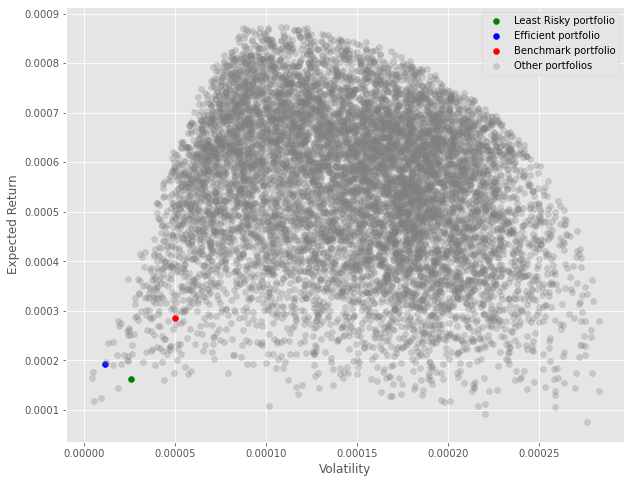

In [62]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlabel("Volatility")
ax.set_ylabel("Expected Return")


# Min Risk Portfolio
ax.scatter(x=lrisk_vol, y=lrisk_returns,
           color='green', label='Least Risky portfolio')

# Efficient Portfolio
ax.scatter(x=efficient_vol, y=efficient_returns,
           color='Blue', label='Efficient portfolio')

# Benchmark Portfolio
ax.scatter(x=benchmark_vol, y=benchmark_returns,
           color='Red', label='Benchmark portfolio')

# Feasible Set
ax.scatter(x= np.apply_along_axis(portfolio_vol, 1, weights),
        y= np.apply_along_axis(portfolio_return, 1, weights),
        color='gray', label='Other portfolios', alpha=0.3)


feasible_returns = np.sort(np.apply_along_axis(portfolio_return, 1, weights))
feasible_vols = list(map(optimise_prtflio.frontier_risk,feasible_returns))
print(sum([x is None for x in feasible_vols]))
# Efficient Frontier
# ax.plot(feasible_vols, feasible_returns,
#         color='cyan', label='Other portfolios', alpha=0.3)


ax.legend()

NameError: name 'std' is not defined

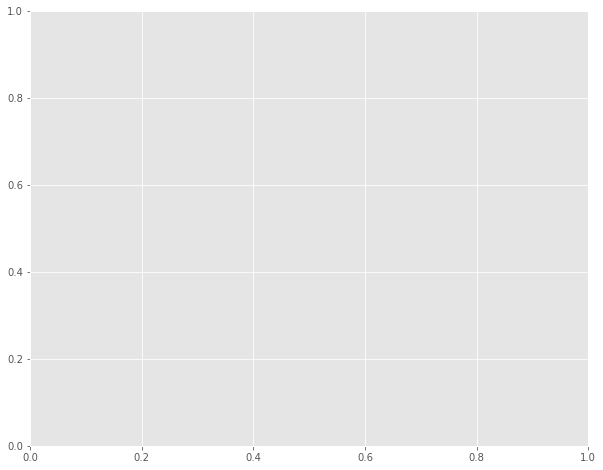

In [125]:

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std, y=delta,
           color='Blue', label='Individual Stocks')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (std[i], delta[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2, delta.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()